# Assignment 1
## Team : Tensor Tamers
### Members: Dharmi Gala | Naman | Kshitij | Vishal Parameswaran

Mandatory Installations

Using LakeFs client v0.113.0.1 to match lakeFS server 0.113.0

In [1]:
# %pip install 'lakefs-client==0.113.0.1' -q

In [2]:
import pandas as pd
import numpy as np
import configparser
import seaborn as sns
import matplotlib.pyplot as plt

#LakeFS Imports
import lakefs_client
from lakefs_client import models
from lakefs_client.client import LakeFSClient
from lakefs_client.api import actions_api

In [3]:
config = configparser.ConfigParser()
config.read('CONFIG/config.ini')
key = config['LAKEFS']['key']
secret = config['LAKEFS']['secret']

Creating the LakeFS client and connecting to server

In [4]:
lakefs_config = lakefs_client.Configuration()
lakefs_config.username = key
lakefs_config.password = secret
lakefs_config.host = 'http://127.0.0.1:8000'

lakefs = LakeFSClient(lakefs_config)

Lets test the connection

In [5]:
lakefs.repositories.list_repositories()

{'pagination': {'has_more': False,
                'max_per_page': 1000,
                'next_offset': '',
                'results': 0},
 'results': []}

Lets make a repository called mlops-tensor-tamers to track our data.

In [6]:
repo = 'mlops-tensor-tamers'
branch = 'main'
fileName = "athletes.csv"
filePath = "../data/athletes.csv"

In [7]:
repo = models.RepositoryCreation(name=repo, storage_namespace='local://', default_branch=branch)
lakefs.repositories_api.create_repository(repo)

{'creation_date': 1697667251,
 'default_branch': 'main',
 'id': 'mlops-tensor-tamers',
 'storage_namespace': 'local://'}

In [8]:
storage_namespace = repo.storage_namespace
repo_id = repo.name
branch = repo.default_branch

Let us upload our data to lakefs

In [9]:
contentToUpload = open(f"{filePath}", 'rb')
lakefs.objects.upload_object(repository=repo_id, branch=branch, path=f'data/{fileName}', content=contentToUpload)

{'checksum': 'ade8057a9ad4350dfade9180f021a96d',
 'content_type': 'text/csv',
 'mtime': 1697667251,
 'path': 'data/athletes.csv',
 'path_type': 'object',
 'physical_address': 'local:///home/lakefs/lakefs/data/block/data/gkfakoi3mo28mq5t2o10/cko5hcq3mo28mq5t2o20',
 'size_bytes': 71546909}

Lets look at our diffs

In [10]:
lakefs.branches.diff_branch(repository=repo_id, branch=branch).results

[{'path': 'data/athletes.csv',
  'path_type': 'object',
  'size_bytes': 71546909,
  'type': 'added'}]

Lets commit our data to the repository

In [11]:
lakefs.commits.commit(
    repository=repo_id,
    branch=branch,
    commit_creation=models.CommitCreation(message='Added Athletes.csv | Version: 1', metadata={'using': 'python_api'}))

{'committer': 'quickstart',
 'creation_date': 1697667251,
 'id': '27f9bb2ae1111f803fefc840c71946709744a16f5f396571f68d93f98ad6c55b',
 'message': 'Added Athletes.csv | Version: 1',
 'meta_range_id': '',
 'metadata': {'using': 'python_api'},
 'parents': ['21991cae35e5f3454739cbd6ea45418a40313df0e3442cdac6a981f2ec741cc8']}

Lets use the main branch to store the original code. We can make newer branches when we make changes. As we will have to track commit ID's to track changes in our code, it makes more sense to create branches when we make changes

Lets read from LakeFs | This is version 1 of the data

In [12]:
data = lakefs.objects.get_object(repository=repo_id, ref=branch, path=f'data/{fileName}')
df = pd.read_csv(data)
df.head()

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


## EDA V1

Lets explore the data.

In [13]:
df.columns

Index(['athlete_id', 'name', 'region', 'team', 'affiliate', 'gender', 'age',
       'height', 'weight', 'fran', 'helen', 'grace', 'filthy50', 'fgonebad',
       'run400', 'run5k', 'candj', 'snatch', 'deadlift', 'backsq', 'pullups',
       'eat', 'train', 'background', 'experience', 'schedule', 'howlong'],
      dtype='object')

In [14]:
df.describe()

,athlete_id,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups
count,423003.000000,331110.000000,1.598690e+05,229890.000000,5.542600e+04,3.027900e+04,4.074500e+04,1.935900e+04,2.973800e+04,2.224600e+04,3.609700e+04,1.044350e+05,9.728000e+04,1.153230e+05,1.105170e+05,5.060800e+04
mean,292748.166538,32.516750,1.206217e+02,170.896137,9.886691e+02,1.207950e+03,5.766025e+02,2.127863e+03,1.472252e+03,5.241279e+02,3.411464e+03,2.709107e+02,2.424957e+02,6.970503e+02,5.852109e+02,4.269613e+04
std,184969.660327,7.730671,2.097995e+04,58.379799,7.200430e+04,6.824091e+04,4.891145e+04,6.055021e+04,9.762688e+04,5.628804e+04,1.251980e+05,2.596882e+04,2.708942e+04,5.523235e+04,5.052976e+04,9.546078e+06
min,82.000000,13.000000,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,-6.000000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-4.500000e+01,0.000000e+00,-5.000000e+02,-7.000000e+00,-6.000000e+00
25%,135091.500000,27.000000,6.600000e+01,145.000000,2.150000e+02,5.250000e+02,1.490000e+02,1.308000e+03,2.400000e+02,6.200000e+01,1.242000e+03,1.400000e+02,1.050000e+02,2.550000e+02,2.050000e+02,1.500000e+01
50%,275839.000000,31.000000,6.900000e+01,170.000000,2.900000e+02,5.950000e+02,1.930000e+02,1.550000e+03,2.940000e+02,7.100000e+01,1.380000e+03,1.950000e+02,1.450000e+02,3.450000e+02,2.750000e+02,2.700000e+01
75%,473188.000000,37.000000,7.200000e+01,192.000000,3.920000e+02,6.940000e+02,2.620000e+02,1.809000e+03,3.360000e+02,8.400000e+01,1.560000e+03,2.350000e+02,1.850000e+02,4.150000e+02,3.350000e+02,3.900000e+01
max,633083.000000,125.000000,8.388607e+06,20175.000000,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,8.388607e+06,2.147484e+09


Lets get columns that are non number.

In [15]:
df_num = df.select_dtypes(exclude=[np.number])
df_num

,name,region,team,affiliate,gender,eat,train,background,experience,schedule,howlong
0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,Derek Abdella,NaN,NaN,NaN,Male,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,Bryce Abbey,NaN,NaN,NaN,Male,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|
...,...,...,...,...,...,...,...,...,...,...,...
423001,Odo Renata,Latin America,Team Guarujá Inox,CrossFit Guaruja,Female,NaN,NaN,NaN,NaN,NaN,NaN
423002,Lozzie Trevor,Australia,FBP CrossFit Games Team,FBP CrossFit,Female,NaN,NaN,NaN,NaN,NaN,NaN
423003,Marisol Smith,North West,CrossFit Oak Harbor,CrossFit Oak Harbor,Female,NaN,NaN,NaN,NaN,NaN,NaN
423004,Pedrini Morgane,Europe,NaN,CrossFit 67,Female,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|,NaN,I began CrossFit with a coach (e.g. at an affi...,I usually only do 1 workout a day|I strictly s...,6-12 months|


We can see that the name and athlete_id column does not contribute any value to the model and is a breach of PPI, so we will be dropping it. 

In [16]:
df = df.drop(columns=['name','athlete_id'])

Lets take a look at the unique values in the other text columns:

In [17]:
#regenerate the columns with only string data
df_num = df.select_dtypes(exclude=[np.number])

for column in df_num.columns:
    print("---"*30)
    print(f"column name: {column}")
    print(df[column].unique())
    print("Number of unique values: ", len(df[column].unique()))

------------------------------------------------------------------------------------------
column name: region
['South West' nan 'Southern California' 'South Central' 'Central East'
 'Europe' 'North East' 'Africa' 'South East' 'Australia'
 'Northern California' 'Latin America' 'Canada East' 'North Central'
 'North West' 'Mid Atlantic' 'Canada West' 'Asia']
Number of unique values:  18
------------------------------------------------------------------------------------------
column name: team
['Double Edge' nan 'LAX CrossFit' ... 'CrossFit AC' 'BLACK SHEEP'
 'CrossFit DV8']
Number of unique values:  4533
------------------------------------------------------------------------------------------
column name: affiliate
['Double Edge CrossFit' nan 'LAX CrossFit' ... 'Black and Gold CrossFit'
 'Reebok CrossFit Gurgaon' 'CrossFit Shardana']
Number of unique values:  9779
------------------------------------------------------------------------------------------
column name: gender
['Male' nan 

It is clear that the columns: Howlong, schedule, experience, background, train and eat are MCQ questions. We should identify the individual values and create dummies. 

But before we procees any further, we should remove all nans to make the process easier.

In [18]:
df = df.dropna(subset=df_num.columns)

This is a pseudo dummies method, as the various options are split by |

In [19]:
def generate_dummies(df,columns):
    for column in columns:
        columns = pd.unique(df[column].str.split("|", expand=True).stack())
        columns = [x for x in columns if x != '']
        dfs = df[column].str.get_dummies(sep='|').reindex(columns, axis=1, fill_value=0).astype(bool)
        df = pd.concat([df, dfs], axis=1)
        df.drop(columns = [column], axis=1, inplace=True) 
    return df

Lets drop the team and affiliate columns as they have way too many unique columns. 

In [20]:
df = df.drop(columns=['team','affiliate'])

Lets generate dummies for region and gender 

In [21]:
df = pd.get_dummies(df,columns=['region','gender'],dtype=bool)

In [22]:
df.drop(columns=['gender_--'], inplace=True)

Now that we're done with the basics, lets generate the dummies for the aforementioned columns

In [23]:
df = generate_dummies(df,["howlong", "schedule", "experience", "background", "train", "eat"])

We should calculate the totalLift score

In [24]:
df['total_lift'] = df['candj'] + df['snatch'] + df['deadlift'] + df['backsq']

I consider this version to be the actual baseline version we can make a model on, as the basic data cleaning has been completed. Lets create a new branch called cleaned_main and commit the data to it.

In [25]:
df.to_csv('../data/athletes.csv', index=False)

In [26]:
branch = "cleaned_main"
lakefs.branches.create_branch(repo_id, models.BranchCreation(name=branch,source='main'))
contentToUpload = open(f"{filePath}", 'rb')
lakefs.objects.upload_object(repository=repo_id, branch=branch, path=f'data/{fileName}', content=contentToUpload)
lakefs.commits.commit(
    repository=repo_id,
    branch=branch,
    commit_creation=models.CommitCreation(message='cleaned main Athletes.csv | Version: 1.1', metadata={'using': 'python_api','changes':'cleaned data'}))

{'committer': 'quickstart',
 'creation_date': 1697667254,
 'id': '9eec4d77ded8bb89251d94dc0aaa373bf81cddccd656181c30b3c7749c2d6c67',
 'message': 'cleaned main Athletes.csv | Version: 1.1',
 'meta_range_id': '',
 'metadata': {'changes': 'cleaned data', 'using': 'python_api'},
 'parents': ['27f9bb2ae1111f803fefc840c71946709744a16f5f396571f68d93f98ad6c55b']}

### We will be using the brain cleaned main to refer to Version 1 for modelling.

### Let us now clean the data further 

In [27]:
data = lakefs.objects.get_object(repository=repo_id, ref=branch, path=f'data/{fileName}')
df = pd.read_csv(data)
df.head()

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,...,"I workout mostly at home, work, or a traditional gym",I write my own programming,Decline to answer.4,I eat 1-3 full cheat meals per week,I eat quality foods but don't measure the amount,I eat whatever is convenient,I eat strict Paleo,I weigh and measure my food,Decline to answer.5,total_lift
0,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,...,False,False,False,True,False,False,False,False,False,1145.0
1,21.0,72.0,175.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,False,False,False,True,True,False,False,False,False,0.0
2,43.0,71.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,0.0
3,30.0,71.0,200.0,243.0,NaN,164.0,NaN,298.0,NaN,1584.0,...,False,False,False,False,False,True,False,False,False,1110.0
4,28.0,70.0,176.0,720.0,680.0,NaN,NaN,280.0,NaN,NaN,...,False,False,False,True,False,False,False,False,False,910.0


Lets take a look at the numerical columns

In [28]:
df_num = df.select_dtypes(exclude=[bool])
df_num

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups,total_lift
0,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,245.0,200.0,375.0,325.0,25.0,1145.0
1,21.0,72.0,175.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,43.0,71.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,30.0,71.0,200.0,243.0,NaN,164.0,NaN,298.0,NaN,1584.0,235.0,175.0,385.0,315.0,35.0,1110.0
4,28.0,70.0,176.0,720.0,680.0,NaN,NaN,280.0,NaN,NaN,187.0,134.0,335.0,254.0,27.0,910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37673,22.0,72.0,174.0,NaN,NaN,345.0,NaN,NaN,NaN,NaN,115.0,95.0,175.0,115.0,NaN,500.0
37674,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0,155.0,NaN,NaN
37675,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.0,NaN,NaN,NaN
37676,19.0,60.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,1441.0,133.0,93.0,240.0,173.0,NaN,639.0


Lets remove nulls from the dataset

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37678 entries, 0 to 37677
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   age                                                       37678 non-null  float64
 1   height                                                    34644 non-null  float64
 2   weight                                                    33201 non-null  float64
 3   fran                                                      16115 non-null  float64
 4   helen                                                     9694 non-null   float64
 5   grace                                                     12761 non-null  float64
 6   filthy50                                                  6288 non-null   float64
 7   fgonebad                                                  9701 non-null   float64
 8   run400          

We can see that columns like fran helen filthy50 fgonebad run400 have too few values to impute. so we drop them, We can also remove nulls from the rest and impute values for grace and run5k

In [30]:
df = df.drop(columns=['filthy50','fgonebad','run400','helen'])

In [31]:
df = df.dropna(subset=['height','weight','snatch','deadlift','backsq'])

In [32]:
df_num = df.select_dtypes(exclude=[bool])
df_num

,age,height,weight,fran,grace,run5k,candj,snatch,deadlift,backsq,pullups,total_lift
1,21.0,72.0,175.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,43.0,71.0,185.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,30.0,71.0,200.0,243.0,164.0,1584.0,235.0,175.0,385.0,315.0,35.0,1110.0
4,28.0,70.0,176.0,720.0,NaN,NaN,187.0,134.0,335.0,254.0,27.0,910.0
5,35.0,68.0,225.0,215.0,112.0,NaN,285.0,205.0,440.0,405.0,24.0,1335.0
...,...,...,...,...,...,...,...,...,...,...,...,...
37668,39.0,75.0,186.0,980.0,NaN,NaN,145.0,85.0,245.0,135.0,NaN,610.0
37669,24.0,70.0,174.0,NaN,NaN,1059.0,143.0,121.0,351.0,287.0,12.0,902.0
37672,25.0,64.0,126.0,659.0,NaN,NaN,110.0,88.0,243.0,176.0,12.0,617.0
37673,22.0,72.0,174.0,NaN,345.0,NaN,115.0,95.0,175.0,115.0,NaN,500.0


Lets take a look at the box plots to identify outliers etc.

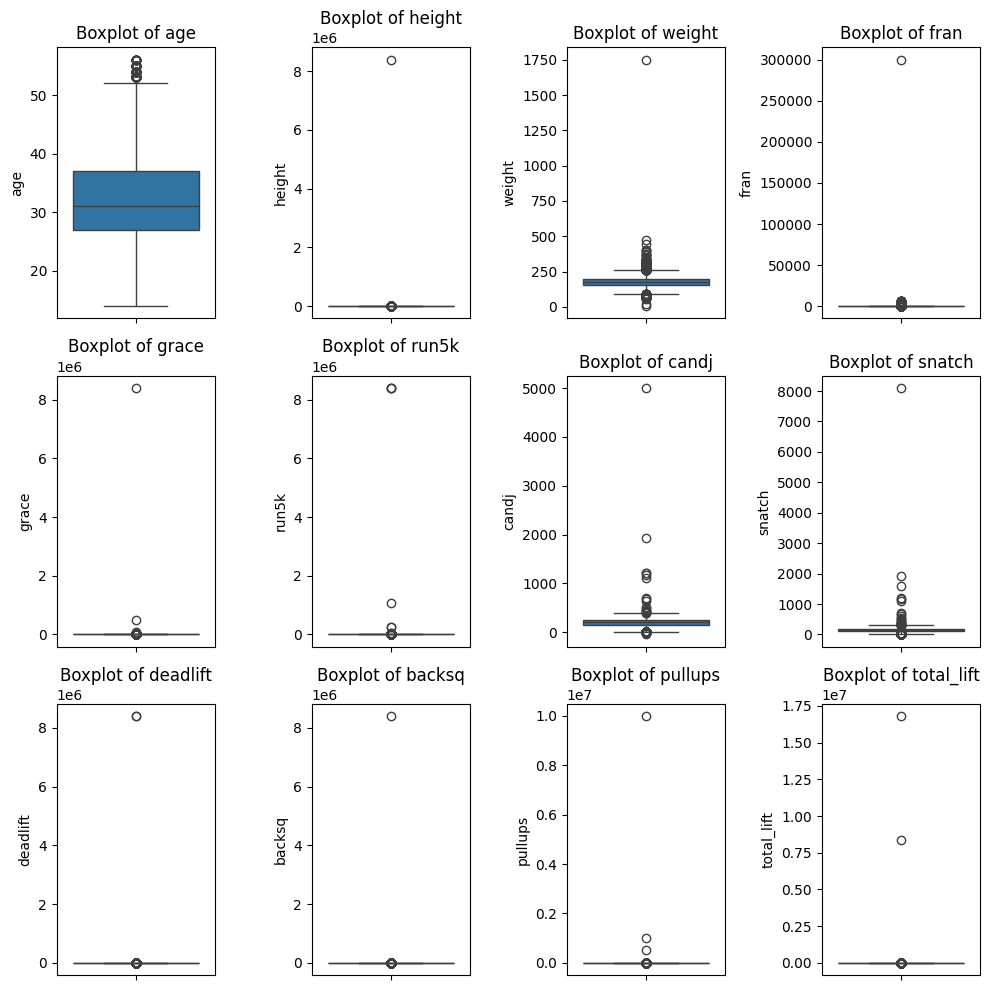

In [33]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
axes = axes.ravel()
for i, feature in enumerate(df_num.columns):
    sns.boxplot(y=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

We can clearly see that for 
1.  Any age above 50 is an outlier, ages <18 should also be removed
2.  Any height above 100, seems to be wrong.
3.  Any weight above 250 should be removed and treated as an outlier
4.  Any fran above 1000
5.  Any helen above 1000
6.  Any grace above 219
7.  Any filthy50 above 1652
8.  Any fgonebad above 400
9.  Any run400 above 1000
10. Any run5k above 1459
11. Any candj above 450.
12. Any snatch above 450
13. Any deadlift above 700
14. Any backsq above 700
15. Any pullups above 490

In [34]:
# Remove Outliers
df = df[((df['age'] < 50) & (df['age'] > 18)) | (df['age'].isna())]
df = df[((df['height'] < 80) & (df['height']>60)) | (df['height'].isna())]
df = df[((df['weight'] < 500) & (df['weight'] > 100))  | (df['weight'].isna())]
df = df[(df['fran'] < 800) | (df['fran'].isna())]
df = df[(df['grace'] < 1000) | (df['grace'].isna())]
# df = df[((df['run5k'] < 2000) & (df['run5k'] > 1000)) | (df['run5k'].isna())]
# df = df[((df['candj'] < 200) & (df['candj']  > 50))  | (df['candj'].isna())]
# df = df[(df['snatch'] < 500)  | (df['snatch'].isna())]
# df = df[((df['deadlift'] < 600) & (df['deadlift']>290))  | (df['height'].isna())]
# df = df[((df['backsq'] < 500) & (df['backsq'] > 200))  | (df['backsq'].isna())]
# df = df[(df['pullups'] < 75)  | (df['pullups'].isna())]

lets review the box plots again

In [35]:
df_num.columns

Index(['age', 'height', 'weight', 'fran', 'grace', 'run5k', 'candj', 'snatch',
       'deadlift', 'backsq', 'pullups', 'total_lift'],
      dtype='object')

In [36]:
g = sns.PairGrid(df[df_num.columns])
g.map_diag(sns.histplot)
g.map_offdiag(sns.kdeplot)

It seems that all the outliers are taken care of now.

Let us impute the values for the columns now.

<Axes: xlabel='height', ylabel='Count'>

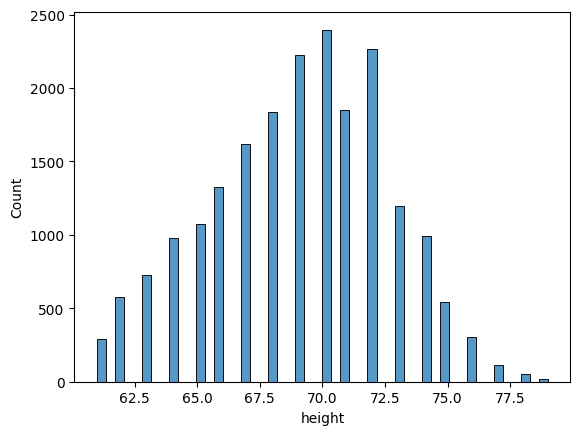

In [39]:
sns.histplot(df['height'],ax=axes[i])

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20399 entries, 1 to 37673
Data columns (total 71 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   age                                                       20399 non-null  float64
 1   height                                                    20399 non-null  float64
 2   weight                                                    20399 non-null  float64
 3   fran                                                      12435 non-null  float64
 4   grace                                                     10007 non-null  float64
 5   run5k                                                     7787 non-null   float64
 6   candj                                                     19934 non-null  float64
 7   snatch                                                    20399 non-null  float64
 8   deadlift        

In [ ]:
# Remove Outliers
df = df[((df['age'] < 50) & (df['age'] > 18)) | (df['age'].isna())]
df = df[((df['height'] < 100) & (df['height']>60)) | (df['height'].isna())]
df = df[((df['weight'] < 250) & (df['weight'] > 100))  | (df['weight'].isna())]
df = df[(df['fran'] < 325) | (df['fran'].isna())]
df = df[(df['grace'] < 219) | (df['grace'].isna())]
df = df[((df['run5k'] < 2000) & (df['run5k'] > 1000)) | (df['run5k'].isna())]
df = df[((df['candj'] < 200) & (df['candj']  > 50))  | (df['candj'].isna())]
df = df[(df['snatch'] < 290)  | (df['snatch'].isna())]
df = df[((df['deadlift'] < 600) & (df['deadlift']>290))  | (df['height'].isna())]
df = df[((df['backsq'] < 500) & (df['backsq'] > 200))  | (df['backsq'].isna())]
df = df[(df['pullups'] < 75)  | (df['pullups'].isna())]

Lets check the correlation of the variables
First lets check the numerical columns

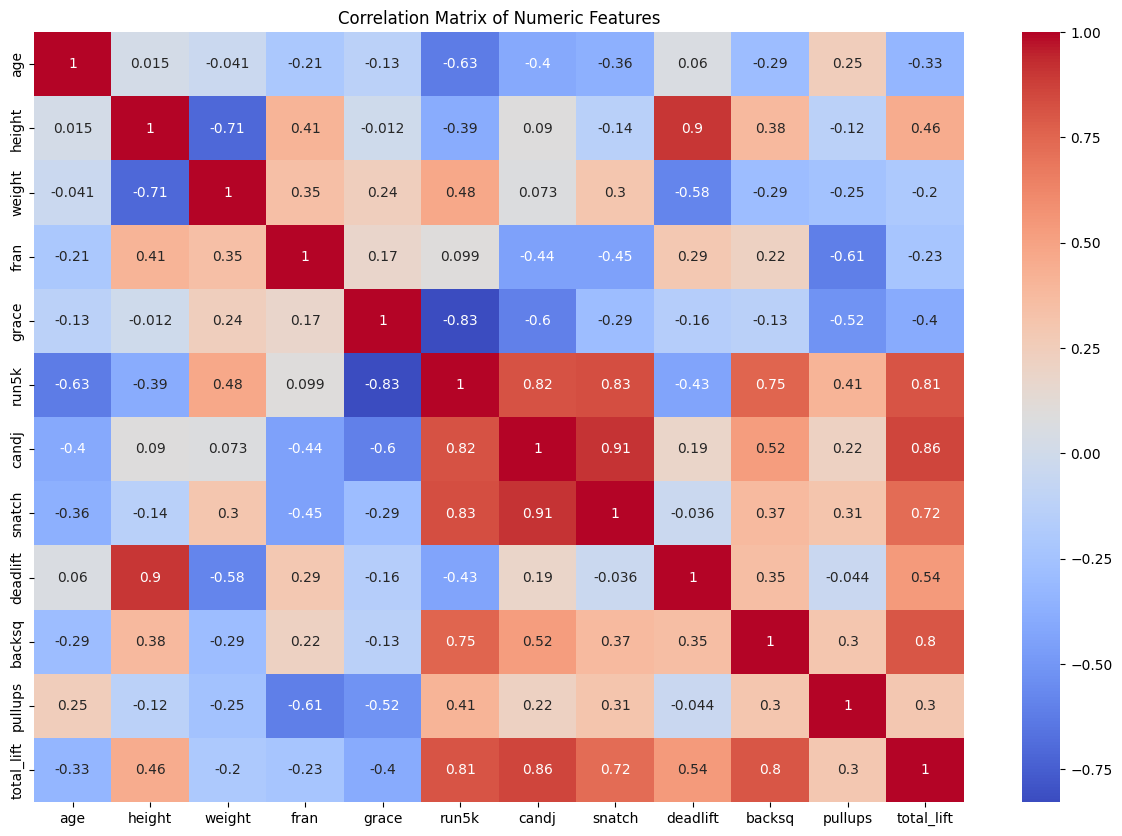

In [108]:
corr_matrix = df.select_dtypes(exclude=[object,bool]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

Because the total_lift column is built off of candj,snatch,deadlift ad backsp, it would be wise to address it later on.

### Storing the Data

Lets commit our data to the branch cleaned_complete

In [42]:
df.to_csv('../data/athletes.csv', index=False)

In [43]:
branch = "cleaned_complete"
lakefs.branches.create_branch(repository=repo_id, branch_creation=models.BranchCreation(name=branch,source='main'))
contentToUpload = open(file=f"{filePath}", mode='rb')
lakefs.objects.upload_object(repository=repo_id, branch=branch, path=f'data/{fileName}', content=contentToUpload)
lakefs.commits.commit(
    repository=repo_id,
    branch=branch,
    commit_creation=models.CommitCreation(message='cleaned data and features extraction Athletes.csv | Version: 2', metadata={'using': 'python_api','changes':'features extraced'}))

{'committer': 'quickstart',
 'creation_date': 1697658367,
 'id': '1410f9cb06a26f26baf0a79e856c225ac599d7b9f8c2e44513daa9022b5e24fe',
 'message': 'cleaned data and features extraction Athletes.csv | Version: 2',
 'meta_range_id': '',
 'metadata': {'changes': 'features extraced', 'using': 'python_api'},
 'parents': ['1b61cfa8ed187a1436c7ce3eb9fe34bddbc3dd93c5b2ad6cce736ef1524a29e9']}

## Data Modelling

lets work on modelling our data now.

In [44]:
#convert boolean columns to int
def convert_bool(df):
    for column in df.columns:
        if df[column].dtype == bool:
            df[column] = df[column].astype(int)
    return df

In [56]:
# Mandatory Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt

Let us make a pipeline, through which we will process the data

In [48]:
pipe = Pipeline([
  ('normalization', StandardScaler()), # Scale and standardize the data
  ('feature_selection', SelectFromModel(LinearSVC(loss='squared_hinge', penalty='l1', dual=False))), # Select features we want to use
  ('Regression', XGBRegressor()) # Use XGBoost to train the model
])

### Using Data from V1

Lets convert the data into train and test sets

In [49]:
import gc
gc.collect()

70411

In [50]:
branch="cleaned_main"
data = lakefs.objects.get_object(repository=repo_id, ref=branch, path=f'data/{fileName}')
df = pd.read_csv(filepath_or_buffer=data)
df.head()

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,...,"I workout mostly at home, work, or a traditional gym",I write my own programming,Decline to answer.4,I eat 1-3 full cheat meals per week,I eat quality foods but don't measure the amount,I eat whatever is convenient,I eat strict Paleo,I weigh and measure my food,Decline to answer.5,total_lift
0,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,...,False,False,False,True,False,False,False,False,False,1145.0
1,21.0,72.0,175.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,False,False,False,True,True,False,False,False,False,0.0
2,43.0,71.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,0.0
3,30.0,71.0,200.0,243.0,NaN,164.0,NaN,298.0,NaN,1584.0,...,False,False,False,False,False,True,False,False,False,1110.0
4,28.0,70.0,176.0,720.0,680.0,NaN,NaN,280.0,NaN,NaN,...,False,False,False,True,False,False,False,False,False,910.0


The data contains nans, so we should either impute or delete them.

In [51]:
df = df.dropna()

In [52]:
df = convert_bool(df=df)

Lets split the data

In [53]:
X_train, X_test , y_train, Y_test = train_test_split(df.drop(columns=['total_lift']), df['total_lift'], test_size=0.2, random_state=42)

Lets train the model and evaluate it.

In [58]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Mean Absolute Error (MAE) for v1: {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) for v1: {sqrt(mse):.4f}")
print(f"R^2 Score for v1: {r2:.4f}")

Mean Absolute Error (MAE) for v1: 37.7649
Root Mean Squared Error (RMSE) for v1: 214.9718
R^2 Score for v1: 0.6113


/home/sausagemadness/miniconda3/envs/mlops/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


This is not a great model, and the issue is most likely the data that wasnt cleaned. Lets work on the cleaned data

## Using Data V2

In [59]:
import gc
gc.collect()

58

In [60]:
branch="cleaned_complete"
data = lakefs.objects.get_object(repository=repo_id, ref=branch, path=f'data/{fileName}')
df = pd.read_csv(filepath_or_buffer=data)
df.head()

,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,...,"I workout mostly at home, work, or a traditional gym",I write my own programming,Decline to answer.4,I eat 1-3 full cheat meals per week,I eat quality foods but don't measure the amount,I eat whatever is convenient,I eat strict Paleo,I weigh and measure my food,Decline to answer.5,total_lift
0,37.0,72.0,210.0,162.0,482.0,143.0,1243.0,366.0,66.0,1320.0,...,False,True,False,True,True,False,False,False,False,1440.0
1,44.0,73.0,184.0,317.0,586.0,217.0,1551.0,311.0,74.0,1454.0,...,False,False,False,False,True,False,False,False,False,1005.0
2,26.0,71.0,195.0,159.0,480.0,118.0,1236.0,388.0,59.0,1278.0,...,False,False,False,False,False,True,False,False,False,1385.0
3,33.0,72.0,205.0,147.0,480.0,143.0,1323.0,339.0,69.0,1292.0,...,False,True,False,False,True,False,False,False,False,1315.0
4,37.0,70.0,165.0,195.0,531.0,165.0,1030.0,361.0,66.0,1181.0,...,False,False,False,False,True,False,False,False,False,1206.0


In [61]:
df = convert_bool(df=df)

In [62]:
X_train, X_test , y_train, Y_test = train_test_split(df.drop(columns=['total_lift']), df['total_lift'], test_size=0.2, random_state=42)

In [63]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mae_v2 = mean_absolute_error(Y_test, y_pred)
mse_v2 = mean_squared_error(Y_test, y_pred)
r2_v2 = r2_score(Y_test, y_pred)

print(f"Mean Absolute Error (MAE) for v2: {mae_v2:.4f}")
print(f"Root Mean Squared Error (RMSE) for v2: {sqrt(mse_v2):.4f}")
print(f"R^2 Score for v2: {r2_v2:.4f}")

/home/sausagemadness/miniconda3/envs/mlops/lib/python3.9/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mean Absolute Error (MAE) for v2: 19.6010
Root Mean Squared Error (RMSE) for v2: 27.1667
R^2 Score for v2: 0.9663


As we can see, this model is much better and is actually viable

## Testing Tensorflows Differential Privacy

Lets check the $\epsilon$ value

In [64]:
import tensorflow as tf
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

2023-10-18 14:52:46.970171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 14:52:46.970212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 14:52:46.970234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 14:52:46.974565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Lets take a look at the $\epsilon$ value for our Dataset V2

In [69]:
l2_norm_clip = 0.8
noise_multiplier = 10
num_microbatches = 1
learning_rate = 0.25
number_of_examples = len(X_train)
batch_size = 100
epochs=20
delta=1e-5


print(compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement(number_of_examples=number_of_examples,
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              num_epochs=epochs,
                                              delta=1e-2))

DP-SGD performed over 252 examples with 100 examples per iteration, noise
multiplier 10 for 20 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 0.01 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:         2.382
    Epsilon assuming Poisson sampling (*):                      1.367

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed the actual epsilon should be
closer to this value than the conservative assumption of an arbitrary data
order.

